In [1]:
import os
from keras.applications import VGG16
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import Model
from tqdm import tqdm
import cv2
import skimage
from keras import models, layers, optimizers
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
import keras
import sklearn
from sklearn.metrics import confusion_matrix
import itertools
from keras.applications.imagenet_utils import preprocess_input

%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
imageSize=224
train_dir = "OCT2017 /train/"
test_dir =  "OCT2017 /test/"

def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'): # ignores the .DS_Store // ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for i,image_filename in enumerate(tqdm(os.listdir(folder + folderName))):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                if i>6000:
                    break
                    
    X = np.asarray(X)
    y = np.asarray(y)

    return X,y


Loads the testing set

In [3]:
X_test, y_test= get_data(test_dir)
y_testHot = to_categorical(y_test, num_classes = 4)

  0%|          | 0/243 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 243/243 [00:02<00:00, 82.24it/s]


Loads the training set (option to make train = test for small playing)

In [4]:
X_train, y_train= get_data(train_dir)
y_trainHot = to_categorical(y_train, num_classes = 4)

# X_train = X_test ###################
# y_train = y_test ###############
# y_trainHot = y_testHot ######################

class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

  0%|          | 0/11348 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  3%|▎         | 1044/37205 [00:16<09:22, 64.32it/s]


  6%|▌         | 2139/37205 [00:33<09:05, 64.26it/s]


  9%|▊         | 3237/37205 [00:50<08:46, 64.55it/s]


 12%|█▏        | 4347/37205 [01:07<08:27, 64.71it/s]


 15%|█▍        | 5420/37205 [01:24<08:14, 64.34it/s]


 16%|█▌        | 5995/37205 [01:33<08:05, 64.24it/s]

  0%|          | 0/26315 [00:00<?, ?it/s]

  0%|          | 8/26315 [00:00<05:55, 74.06it/s]

  0%|          | 13/26315 [00:00<07:06, 61.65it/s]

  0%|          | 19/26315 [00:00<07:15, 60.36it/s]

  0%|          | 24/26315 [00:00<07:37, 57.42it/s]

  0%|          | 32/26315 [00:00<07:10, 61.07it/s]

  0%|          | 39/26315 [00:00<07:06, 61.58it/s]

  0%|          | 47/26315 [00:00<06:49, 64.08it/s]

  0%|          | 55/26315 [00:00<06:38, 65.83it/s]

  0%|          | 63/26315 [00:00<06:30, 67.27it/s]

  0%|          | 71/26315 [00:01<06:28, 67.49it/s]

  0%|          | 79/26315 [00:01<06:38, 65.84it/s]

  0%|          | 86/26315 [00:01<06:45, 64.76it/s]

  0%|          | 94/26315 [00:01<06:39, 65.67it/s]

  0%|          | 102/26315 [00:01<06:34, 66.41it/s]

  0%|          | 109/26315 [00:01<06:37, 65.91it/s]

  0%|          | 116/26315 [00:01<06:41, 65.17it/s]

  0%|          | 124/26315 [00:01<06:40, 65.43it/s]

  1%|          |

  2%|▏         | 496/26315 [00:07<06:27, 66.57it/s]

  2%|▏         | 503/26315 [00:07<06:29, 66.35it/s]

  2%|▏         | 511/26315 [00:07<06:28, 66.50it/s]

  2%|▏         | 519/26315 [00:07<06:26, 66.66it/s]

  2%|▏         | 527/26315 [00:07<06:27, 66.47it/s]

  2%|▏         | 534/26315 [00:08<06:28, 66.41it/s]

  2%|▏         | 542/26315 [00:08<06:27, 66.45it/s]

  2%|▏         | 549/26315 [00:08<06:27, 66.43it/s]

  2%|▏         | 556/26315 [00:08<06:27, 66.40it/s]

  2%|▏         | 563/26315 [00:08<06:28, 66.27it/s]

  2%|▏         | 572/26315 [00:08<06:27, 66.44it/s]

  2%|▏         | 579/26315 [00:08<06:27, 66.43it/s]

  2%|▏         | 586/26315 [00:08<06:27, 66.38it/s]

  2%|▏         | 593/26315 [00:08<06:27, 66.39it/s]

  2%|▏         | 600/26315 [00:09<06:28, 66.23it/s]

  2%|▏         | 607/26315 [00:09<06:28, 66.20it/s]

  2%|▏         | 616/26315 [00:09<06:27, 66.37it/s]

  2%|▏         | 623/26315 [00:09<06:27, 66.34it/s]

  2%|▏         | 630/26315 [00:09<06:28, 66.14

  6%|▌         | 1563/26315 [00:23<06:05, 67.72it/s]

  6%|▌         | 1571/26315 [00:23<06:05, 67.69it/s]

  6%|▌         | 1579/26315 [00:23<06:05, 67.62it/s]

  6%|▌         | 1587/26315 [00:23<06:05, 67.67it/s]

  6%|▌         | 1595/26315 [00:23<06:05, 67.70it/s]

  6%|▌         | 1603/26315 [00:23<06:05, 67.66it/s]

  6%|▌         | 1611/26315 [00:23<06:05, 67.68it/s]

  6%|▌         | 1618/26315 [00:23<06:05, 67.65it/s]

  6%|▌         | 1625/26315 [00:24<06:05, 67.56it/s]

  6%|▌         | 1632/26315 [00:24<06:05, 67.50it/s]

  6%|▌         | 1640/26315 [00:24<06:05, 67.55it/s]

  6%|▋         | 1647/26315 [00:24<06:05, 67.52it/s]

  6%|▋         | 1655/26315 [00:24<06:05, 67.56it/s]

  6%|▋         | 1663/26315 [00:24<06:04, 67.56it/s]

  6%|▋         | 1670/26315 [00:24<06:04, 67.54it/s]

  6%|▋         | 1678/26315 [00:24<06:04, 67.58it/s]

  6%|▋         | 1687/26315 [00:24<06:04, 67.62it/s]

  6%|▋         | 1695/26315 [00:25<06:04, 67.60it/s]

  6%|▋         | 1702/26315 

 10%|▉         | 2631/26315 [00:38<05:47, 68.06it/s]

 10%|█         | 2639/26315 [00:38<05:47, 68.08it/s]

 10%|█         | 2647/26315 [00:38<05:47, 68.11it/s]

 10%|█         | 2655/26315 [00:38<05:47, 68.10it/s]

 10%|█         | 2663/26315 [00:39<05:47, 68.09it/s]

 10%|█         | 2671/26315 [00:39<05:47, 68.10it/s]

 10%|█         | 2678/26315 [00:39<05:47, 68.09it/s]

 10%|█         | 2686/26315 [00:39<05:46, 68.12it/s]

 10%|█         | 2694/26315 [00:39<05:46, 68.14it/s]

 10%|█         | 2702/26315 [00:39<05:46, 68.17it/s]

 10%|█         | 2710/26315 [00:39<05:46, 68.19it/s]

 10%|█         | 2719/26315 [00:39<05:45, 68.23it/s]

 10%|█         | 2728/26315 [00:39<05:45, 68.26it/s]

 10%|█         | 2736/26315 [00:40<05:45, 68.25it/s]

 10%|█         | 2744/26315 [00:40<05:45, 68.24it/s]

 10%|█         | 2752/26315 [00:40<05:45, 68.27it/s]

 10%|█         | 2760/26315 [00:40<05:44, 68.29it/s]

 11%|█         | 2769/26315 [00:40<05:44, 68.33it/s]

 11%|█         | 2777/26315 

 14%|█▍        | 3707/26315 [00:54<05:29, 68.53it/s]

 14%|█▍        | 3715/26315 [00:54<05:29, 68.56it/s]

 14%|█▍        | 3723/26315 [00:54<05:29, 68.57it/s]

 14%|█▍        | 3731/26315 [00:54<05:29, 68.57it/s]

 14%|█▍        | 3739/26315 [00:54<05:29, 68.58it/s]

 14%|█▍        | 3747/26315 [00:54<05:28, 68.60it/s]

 14%|█▍        | 3755/26315 [00:54<05:28, 68.61it/s]

 14%|█▍        | 3763/26315 [00:54<05:28, 68.60it/s]

 14%|█▍        | 3771/26315 [00:54<05:28, 68.61it/s]

 14%|█▍        | 3780/26315 [00:55<05:28, 68.63it/s]

 14%|█▍        | 3788/26315 [00:55<05:28, 68.61it/s]

 14%|█▍        | 3795/26315 [00:55<05:28, 68.56it/s]

 14%|█▍        | 3802/26315 [00:55<05:28, 68.55it/s]

 14%|█▍        | 3810/26315 [00:55<05:28, 68.56it/s]

 15%|█▍        | 3818/26315 [00:55<05:28, 68.55it/s]

 15%|█▍        | 3825/26315 [00:55<05:28, 68.54it/s]

 15%|█▍        | 3833/26315 [00:55<05:27, 68.56it/s]

 15%|█▍        | 3840/26315 [00:56<05:27, 68.54it/s]

 15%|█▍        | 3848/26315 

 18%|█▊        | 4782/26315 [01:09<05:14, 68.47it/s]

 18%|█▊        | 4791/26315 [01:09<05:14, 68.49it/s]

 18%|█▊        | 4799/26315 [01:10<05:14, 68.49it/s]

 18%|█▊        | 4807/26315 [01:10<05:13, 68.51it/s]

 18%|█▊        | 4815/26315 [01:10<05:13, 68.50it/s]

 18%|█▊        | 4823/26315 [01:10<05:13, 68.50it/s]

 18%|█▊        | 4831/26315 [01:10<05:13, 68.47it/s]

 18%|█▊        | 4839/26315 [01:10<05:13, 68.49it/s]

 18%|█▊        | 4847/26315 [01:10<05:13, 68.49it/s]

 18%|█▊        | 4856/26315 [01:10<05:13, 68.49it/s]

 18%|█▊        | 4863/26315 [01:11<05:13, 68.48it/s]

 19%|█▊        | 4870/26315 [01:11<05:13, 68.47it/s]

 19%|█▊        | 4877/26315 [01:11<05:13, 68.46it/s]

 19%|█▊        | 4885/26315 [01:11<05:12, 68.47it/s]

 19%|█▊        | 4893/26315 [01:11<05:12, 68.48it/s]

 19%|█▊        | 4901/26315 [01:11<05:12, 68.48it/s]

 19%|█▊        | 4909/26315 [01:11<05:12, 68.48it/s]

 19%|█▊        | 4918/26315 [01:11<05:12, 68.50it/s]

 19%|█▊        | 4926/26315 

 22%|██▏       | 5845/26315 [01:25<04:58, 68.53it/s]

 22%|██▏       | 5853/26315 [01:25<04:58, 68.53it/s]

 22%|██▏       | 5861/26315 [01:25<04:58, 68.53it/s]

 22%|██▏       | 5870/26315 [01:25<04:58, 68.55it/s]

 22%|██▏       | 5878/26315 [01:25<04:58, 68.54it/s]

 22%|██▏       | 5886/26315 [01:25<04:58, 68.53it/s]

 22%|██▏       | 5895/26315 [01:26<04:57, 68.55it/s]

 22%|██▏       | 5904/26315 [01:26<04:57, 68.56it/s]

 22%|██▏       | 5912/26315 [01:26<04:57, 68.56it/s]

 22%|██▏       | 5920/26315 [01:26<04:57, 68.56it/s]

 23%|██▎       | 5928/26315 [01:26<04:57, 68.57it/s]

 23%|██▎       | 5936/26315 [01:26<04:57, 68.58it/s]

 23%|██▎       | 5944/26315 [01:26<04:56, 68.59it/s]

 23%|██▎       | 5952/26315 [01:26<04:56, 68.58it/s]

 23%|██▎       | 5960/26315 [01:26<04:56, 68.57it/s]

 23%|██▎       | 5969/26315 [01:27<04:56, 68.58it/s]

 23%|██▎       | 5977/26315 [01:27<04:56, 68.59it/s]

 23%|██▎       | 5985/26315 [01:27<04:56, 68.58it/s]

 23%|██▎       | 5993/26315 

 10%|█         | 869/8616 [00:12<01:54, 67.72it/s]


 10%|█         | 877/8616 [00:12<01:54, 67.71it/s]


 10%|█         | 885/8616 [00:13<01:54, 67.77it/s]


 10%|█         | 893/8616 [00:13<01:53, 67.80it/s]


 10%|█         | 901/8616 [00:13<01:53, 67.80it/s]


 11%|█         | 909/8616 [00:13<01:53, 67.64it/s]


 11%|█         | 917/8616 [00:13<01:53, 67.69it/s]


 11%|█         | 924/8616 [00:13<01:53, 67.65it/s]


 11%|█         | 931/8616 [00:13<01:53, 67.60it/s]


 11%|█         | 938/8616 [00:13<01:53, 67.61it/s]


 11%|█         | 946/8616 [00:13<01:53, 67.65it/s]


 11%|█         | 954/8616 [00:14<01:53, 67.70it/s]


 11%|█         | 962/8616 [00:14<01:53, 67.54it/s]


 11%|█         | 969/8616 [00:14<01:53, 67.43it/s]


 11%|█▏        | 977/8616 [00:14<01:53, 67.51it/s]


 11%|█▏        | 986/8616 [00:14<01:52, 67.64it/s]


 12%|█▏        | 994/8616 [00:14<01:52, 67.72it/s]


 12%|█▏        | 1002/8616 [00:14<01:52, 67.73it/s]


 12%|█▏        | 1010/8616 [00:14<01:52, 67.7

 22%|██▏       | 1883/8616 [00:27<01:38, 68.25it/s]


 22%|██▏       | 1891/8616 [00:27<01:38, 68.25it/s]


 22%|██▏       | 1898/8616 [00:27<01:38, 68.17it/s]


 22%|██▏       | 1905/8616 [00:27<01:38, 68.16it/s]


 22%|██▏       | 1912/8616 [00:28<01:38, 68.14it/s]


 22%|██▏       | 1921/8616 [00:28<01:38, 68.20it/s]


 22%|██▏       | 1929/8616 [00:28<01:38, 68.23it/s]


 22%|██▏       | 1937/8616 [00:28<01:37, 68.22it/s]


 23%|██▎       | 1945/8616 [00:28<01:37, 68.12it/s]


 23%|██▎       | 1953/8616 [00:28<01:37, 68.14it/s]


 23%|██▎       | 1960/8616 [00:28<01:37, 68.03it/s]


 23%|██▎       | 1967/8616 [00:28<01:37, 68.02it/s]


 23%|██▎       | 1974/8616 [00:29<01:37, 68.00it/s]


 23%|██▎       | 1982/8616 [00:29<01:37, 68.04it/s]


 23%|██▎       | 1989/8616 [00:29<01:37, 68.01it/s]


 23%|██▎       | 1997/8616 [00:29<01:37, 68.04it/s]


 23%|██▎       | 2004/8616 [00:29<01:37, 67.97it/s]


 23%|██▎       | 2011/8616 [00:29<01:37, 67.97it/s]


 23%|██▎       | 2018/8616 [

 34%|███▎      | 2901/8616 [00:42<01:23, 68.26it/s]


 34%|███▍      | 2909/8616 [00:42<01:23, 68.28it/s]


 34%|███▍      | 2917/8616 [00:42<01:23, 68.30it/s]


 34%|███▍      | 2925/8616 [00:42<01:23, 68.32it/s]


 34%|███▍      | 2933/8616 [00:42<01:23, 68.30it/s]


 34%|███▍      | 2942/8616 [00:43<01:23, 68.33it/s]


 34%|███▍      | 2951/8616 [00:43<01:22, 68.37it/s]


 34%|███▍      | 2959/8616 [00:43<01:22, 68.36it/s]


 34%|███▍      | 2968/8616 [00:43<01:22, 68.40it/s]


 35%|███▍      | 2976/8616 [00:43<01:22, 68.42it/s]


 35%|███▍      | 2984/8616 [00:43<01:22, 68.44it/s]


 35%|███▍      | 2993/8616 [00:43<01:22, 68.47it/s]


 35%|███▍      | 3001/8616 [00:43<01:22, 68.47it/s]


 35%|███▍      | 3010/8616 [00:43<01:21, 68.51it/s]


 35%|███▌      | 3018/8616 [00:44<01:21, 68.45it/s]


 35%|███▌      | 3026/8616 [00:44<01:21, 68.46it/s]


 35%|███▌      | 3034/8616 [00:44<01:21, 68.49it/s]


 35%|███▌      | 3042/8616 [00:44<01:21, 68.47it/s]


 35%|███▌      | 3050/8616 [

 46%|████▌     | 3953/8616 [00:57<01:07, 68.93it/s]


 46%|████▌     | 3961/8616 [00:57<01:07, 68.95it/s]


 46%|████▌     | 3969/8616 [00:57<01:07, 68.94it/s]


 46%|████▌     | 3977/8616 [00:57<01:07, 68.94it/s]


 46%|████▋     | 3985/8616 [00:57<01:07, 68.96it/s]


 46%|████▋     | 3994/8616 [00:57<01:06, 68.99it/s]


 46%|████▋     | 4002/8616 [00:58<01:06, 68.98it/s]


 47%|████▋     | 4010/8616 [00:58<01:06, 68.97it/s]


 47%|████▋     | 4018/8616 [00:58<01:06, 68.98it/s]


 47%|████▋     | 4026/8616 [00:58<01:06, 68.92it/s]


 47%|████▋     | 4034/8616 [00:58<01:06, 68.94it/s]


 47%|████▋     | 4043/8616 [00:58<01:06, 68.97it/s]


 47%|████▋     | 4051/8616 [00:58<01:06, 68.97it/s]


 47%|████▋     | 4060/8616 [00:58<01:06, 69.00it/s]


 47%|████▋     | 4068/8616 [00:58<01:05, 68.97it/s]


 47%|████▋     | 4076/8616 [00:59<01:05, 68.98it/s]


 47%|████▋     | 4084/8616 [00:59<01:05, 68.97it/s]


 48%|████▊     | 4093/8616 [00:59<01:05, 68.99it/s]


 48%|████▊     | 4101/8616 [

 58%|█████▊    | 5006/8616 [01:12<00:52, 69.10it/s]


 58%|█████▊    | 5014/8616 [01:12<00:52, 69.11it/s]


 58%|█████▊    | 5021/8616 [01:12<00:52, 69.10it/s]


 58%|█████▊    | 5028/8616 [01:12<00:51, 69.06it/s]


 58%|█████▊    | 5035/8616 [01:12<00:51, 69.05it/s]


 59%|█████▊    | 5043/8616 [01:13<00:51, 69.05it/s]


 59%|█████▊    | 5050/8616 [01:13<00:51, 69.04it/s]


 59%|█████▊    | 5058/8616 [01:13<00:51, 69.05it/s]


 59%|█████▉    | 5066/8616 [01:13<00:51, 69.06it/s]


 59%|█████▉    | 5074/8616 [01:13<00:51, 69.07it/s]


 59%|█████▉    | 5082/8616 [01:13<00:51, 69.07it/s]


 59%|█████▉    | 5090/8616 [01:13<00:51, 69.07it/s]


 59%|█████▉    | 5098/8616 [01:13<00:50, 69.08it/s]


 59%|█████▉    | 5106/8616 [01:13<00:50, 69.04it/s]


 59%|█████▉    | 5113/8616 [01:14<00:50, 69.01it/s]


 59%|█████▉    | 5120/8616 [01:14<00:50, 69.00it/s]


 60%|█████▉    | 5128/8616 [01:14<00:50, 69.01it/s]


 60%|█████▉    | 5137/8616 [01:14<00:50, 69.03it/s]


 60%|█████▉    | 5145/8616 [

In [5]:
map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}

In [6]:
# load VGG16
#Get back the convolutional part of a VGG network trained on ImageNet
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()

In [7]:
class_weight1

array([1., 1., 1., 1.])

In [8]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)
        
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

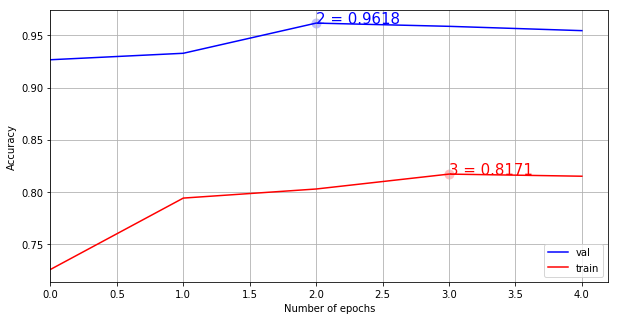

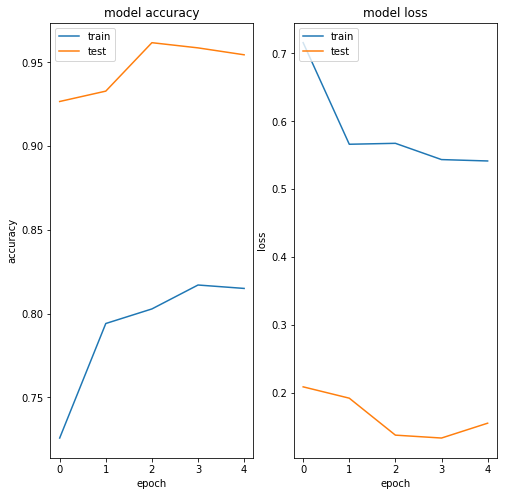

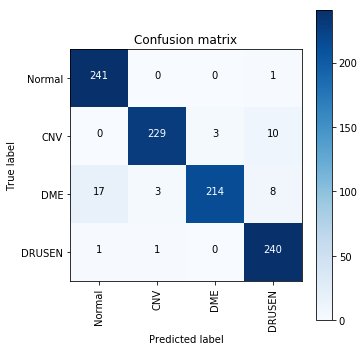

In [9]:
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,classweight,numclasses,numepochs,optimizer,labels):
    base_model = model1 # Topless

    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)

#### Playing with other architectures
#     x = Flatten() (x)
#     x = Dense(64) (x)
#     x = Activation('relu') (x)
#     x = Dropout(0.5) (x)
#     x = Dense(32) (x)
#     x = Activation('relu') (x)
#     x = Dropout(0.5) (x)
####

    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy', 
          optimizer=optimizer, 
          metrics=['accuracy'])

    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
        
    model.summary()

    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    print(history)
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')

    y_pred = model.predict(xtest)
    Y_pred_classes = np.argmax(y_pred,axis = 1)  # reconverts back from one hot encoded 
    Y_true = np.argmax(ytest,axis = 1)  # reconverts back from one hot encoded
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plotKerasLearningCurve()
    plot_learning_curve(history)
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    return model

numepochs = 5#20
pretrainedNetwork(X_train, y_trainHot, 
                 X_test, y_testHot,model1,
                 class_weight1,
                 4,numepochs,optimizer1,map_characters1)